In [1]:
import os
import datetime
import time
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.loader.dataloader import DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

from torch_geometric.data import Data
import torch_geometric
import networkx as nx

from sklearn.model_selection import train_test_split

from ClusterDatasetTransformer import ClusterDataset
from train_transformer import *
from data_statistics import *

from IPython.display import display

from Transformer import Transformer
from lang import Lang
from LossFunction import Loss

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
input_length = 60
max_seq_length = 60
batch_size = 64
max_nodes = 66

In [4]:
converter = Lang(max_nodes)
vocab_size = converter.n_words

In [5]:
# Load the dataset
hist_folder = "/eos/user/c/czeh/histo/"
data_folder_training = "/eos/user/c/czeh/graph_data/processed"
store_folder_training = "/eos/user/c/czeh/graph_data_trans"
data_folder_test = "/eos/user/c/czeh/graph_data_test/processed"
store_folder_test = "/eos/user/c/czeh/graph_data_trans_test"

model_folder = "/eos/user/c/czeh/model"
dataset_training = ClusterDataset(converter, store_folder_training, data_folder_training, max_nodes=max_nodes, input_length=input_length)
dataset_test = ClusterDataset(converter, store_folder_test, data_folder_test, max_nodes=max_nodes, input_length=input_length)

event 0
[[0, 1, 2, 4, 3], [5, 6, 8, 9, 10, 12, 13, 15, 17, 18, 7, 11, 16, 19, 14]]
1
9
event 1
[[0, 1, 2, 4, 5, 8, 10, 12, 6], [3, 9, 11], [7], [13]]
1
3
7
13


Processing...


event 2
[[0, 2, 5, 6, 8, 11, 14, 15, 18, 25, 21, 17, 24, 27, 28, 4, 12, 26, 29, 1, 7, 10, 9, 13, 16, 20, 3, 19, 22, 23]]
1
event 3
[[0, 1, 3, 4, 5, 9, 10, 13, 16, 17, 18, 21, 22, 25, 2, 6, 7, 23, 11, 24, 14, 12, 8, 15, 19, 28, 20, 26, 27]]
1
event 4
[[0, 2, 3, 4, 5, 7, 10, 11, 12, 13, 15, 16, 1, 6, 8, 9], [14]]
2
14
event 5
[[0, 1, 2], [3, 4, 5, 6, 7, 8, 9, 15, 17, 19, 20, 11, 16, 12, 13, 14, 10], [18]]
1
7
18
event 6
[[0, 1, 2, 6], [3, 4, 5, 7, 8, 9, 10]]
0
3
event 7
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 16, 18, 20, 21, 22, 23, 17, 9, 19, 10, 11, 12, 13, 14, 15]]
0
event 8
[[0, 6, 8, 11, 17, 5, 9, 10, 12, 18, 1, 2, 4, 15, 3, 14, 7, 16, 13]]
6
event 9
[[0, 1, 2, 3], [4, 5, 7, 8, 9, 10, 12, 13, 14, 6, 15, 16, 11]]
1
8
event 10
[[0, 1, 2, 3, 4, 5], [6]]
1
6
event 11
[[0, 1, 2, 15, 16, 19, 3, 7, 13, 8, 10, 6, 12, 14, 20, 21, 22, 5, 17, 23, 4, 9, 11, 18]]
5
event 12
[[0, 2, 9], [1, 5, 7, 10, 12, 3, 4, 6, 8, 11, 14, 15], [13]]
0
5
13
event 13
[[0, 1, 5, 6, 8, 18, 20, 25, 28, 30, 33, 34, 35, 36, 38, 

event 77
[[0, 1, 2, 3, 4, 5, 7, 12, 13, 15, 17, 25, 26, 27, 24, 18, 19, 9, 20, 30, 6, 11, 14, 31, 10, 28, 29, 16, 21, 22, 23], [8], [32]]
14
8
32
event 78
[[0, 3, 5, 6, 11, 12, 16, 1, 10, 9], [2, 4, 7, 8, 14, 15], [13]]
1
2
13
event 79
[[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 22, 8, 19, 23, 24, 16, 18, 21, 25, 26, 17, 20]]
0
event 80
[[0, 1, 2, 3, 4, 5, 8, 9, 14, 16, 17, 18, 19, 20, 21, 22, 23, 25, 7, 10, 13, 15, 6, 11, 12, 24]]
3
event 81
[[0, 4, 10, 11, 16, 17, 19, 20, 21, 26, 27, 28, 29, 33, 35, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 24, 25, 12, 36, 40, 45, 6, 7, 1, 5, 8, 13, 14, 18, 32, 2, 22, 30, 15, 34, 9, 23, 31, 3, 50]]
2
event 82
[[0, 1, 3, 16, 17, 24, 25, 38, 39, 41, 43, 48, 50, 51, 53, 54, 4, 5, 7, 12, 30, 31, 42, 46, 52, 44, 18, 26, 28, 32, 47, 27, 2, 6, 8, 9, 10, 13, 19, 20, 21, 22, 23, 29, 40, 49, 11, 15, 36, 45, 33, 35, 37, 14, 34]]
13
event 83
[[0, 1, 2, 3, 4, 5, 8, 13, 20, 21, 26, 27, 29, 30, 31, 32, 33, 36, 16, 11, 17, 19, 35, 38, 14, 34, 6, 7

event 135
[[0, 2, 8, 14, 20, 22, 1, 6, 12, 13, 15, 17, 18, 19, 23, 26, 4, 21, 11, 3, 5, 9, 10, 16], [7, 24, 25]]
1
7
event 136
[[0, 1, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 22, 23, 24, 26, 27, 29], [2, 3, 4, 5, 6, 14, 15, 18, 21, 25, 28]]
9
2
event 137
[[0, 2, 7, 8], [1, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17]]
7
1
event 138
[[0, 2, 5, 6, 9, 11, 14, 17, 19, 22, 28, 23, 27, 29, 30, 1, 4, 8, 13, 15, 31, 7, 18, 21, 3, 10, 12, 16, 20, 24, 25, 26]]
1
event 139
[[0, 9, 12, 14, 19, 21, 1, 3, 4, 7, 11, 13, 15, 17, 18, 20, 22, 25, 2, 5, 6, 10, 16], [8, 23, 24]]
1
8
event 140
[[0, 1, 3, 4, 5, 6, 7, 8, 9, 16, 18, 14, 19, 23, 2, 10, 13, 15, 21, 22, 24, 11, 12, 17, 20, 25]]
13
event 141
[[0, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 1, 7], [12]]
2
12
event 142
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 21, 25, 26, 29, 32, 33, 35, 11, 18, 28, 34, 13, 24, 12, 15, 16, 30, 31, 36, 37, 20, 14, 19, 22, 23, 27]]
1
event 143
[[0, 4, 10, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30], [1, 2, 

22
event 206
[[0, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 4, 1, 3, 5, 2]]
1
event 207
[[0, 1, 2], [3]]
0
3
event 208
[[0, 1, 2, 3, 12], [4, 5, 6, 8, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 9, 19, 7]]
1
8
event 209
[[0, 1, 2, 3, 4, 5, 8, 12, 15, 19, 20, 21, 28, 29, 30, 35, 36, 37, 40, 41, 43, 47, 53, 56, 57, 58, 59, 60, 61, 6, 7, 33, 14, 26, 10, 11, 17, 18, 27, 44, 46, 55, 25, 23, 24, 32, 45, 52, 54, 13, 16, 22, 38, 50, 51, 9, 34, 48, 39, 42, 49, 31]]
13
event 210
[[0, 1, 2, 4], [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]]
2
13
event 211
[[0, 1, 4, 6, 13, 11], [2, 3, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 26, 23]]
0
2
event 212
[[0, 1, 2, 3, 4, 6, 7, 5, 8, 9]]
8
event 213
[[0, 1, 2, 4, 5, 7, 8, 10, 11, 12, 14, 15, 16, 19, 20, 23, 29, 41, 42, 27, 26, 35, 39, 40, 43, 18, 38, 6, 9, 30, 32, 33, 3, 13, 17, 22, 24, 37, 44, 28, 25, 31, 34, 36, 21]]
0
event 214
[[0, 1, 2, 5, 7, 18, 9, 10,

[[0, 2, 5, 13, 17, 18, 19, 20, 10, 11, 4, 1, 3, 7, 8, 12, 15, 6, 9, 14, 16]]
3
event 272
[[0, 1, 10], [2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15], [16]]
1
2
16
event 273
[[0, 6, 7, 8, 9, 10, 11, 12, 13, 14], [1, 2, 3, 4, 5]]
0
1
event 274
[[0, 1, 2, 4, 5, 9, 10, 11, 13, 14, 15, 17, 20, 21, 23, 24, 25, 26, 27, 28, 31, 33, 38, 39, 41, 45, 46, 6, 18, 29, 30, 42, 7, 12, 22, 8, 44, 48, 51, 3, 16, 32, 34, 37, 43, 49, 50, 35, 36, 47, 19, 40]]
2
event 275
[[0, 1, 2, 3, 4, 5, 8, 11, 7, 9, 10, 12, 13, 16, 14, 15], [6]]
0
6
event 276
[[0, 1, 2, 3, 4, 5, 6, 10, 12, 13, 14, 9, 11, 7, 8]]
5
event 277
[[0, 1, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 4, 13, 2, 3, 7, 19, 20, 21, 23, 24, 22]]
19
event 278
[[0, 1, 2, 3, 4, 5, 7, 12, 13, 14, 15, 16, 21, 26, 27, 28, 6, 8, 10, 19, 20, 11, 23, 24, 9, 17, 22, 25, 18]]
6
event 279
[[0, 1, 2, 3, 4, 5, 6, 8, 16, 23, 7, 9, 12, 18, 26, 11, 19, 22, 24, 15, 13, 17, 20, 27, 10, 31, 25, 14, 29, 21, 28, 30]]
17
event 280
[[0, 4], [1, 2, 3, 5, 6, 7, 8], [9]]
4
1
9
e

Done!
Processing...


event 0
[[0, 1, 2, 3, 4, 5, 6], [7]]
0
7
event 1
[[0, 1, 2, 3], [4, 7, 8, 9, 10, 12, 13, 14, 5, 6, 11, 15]]
1
8
event 2
[[0], [1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 6], [7]]
0
2
7
event 3
[[0, 1, 3, 4, 5, 6, 8, 9, 10, 2], [7]]
1
7
event 4
[[0, 1, 4, 6, 12, 14, 15, 18, 19, 20, 2, 3, 21, 24, 25, 17, 5, 7, 8, 11, 13, 16, 22, 9, 10, 23]]
1
event 5
[[0, 3, 4, 5, 6, 7, 8, 9, 14, 18, 15, 11, 16, 12, 13, 10], [1, 2], [17]]
8
2
17
event 6
[[0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 14, 15, 16, 19, 20, 24, 25, 27, 28, 32, 17, 33, 2, 21, 23, 31, 41, 26, 10, 13, 34, 40, 22, 35, 29, 37, 38, 44, 42, 12, 18, 36, 39, 43, 30]]
13
event 7
[[0, 1, 2, 5, 7, 8, 10, 4, 6], [3, 9]]
1
3
event 8
[[0, 2, 8, 9, 10, 26, 1, 3, 13, 5, 6, 7, 27, 4, 29, 14, 15, 17, 18, 19, 20, 21, 22, 30, 31, 32, 11, 16, 23, 24, 25, 12, 28]]
15
event 9
[[0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 16, 22, 25, 28, 29, 32, 34, 36, 5, 23, 24, 27, 31, 35, 12, 13, 17, 18, 21, 33, 37, 14, 19, 20, 26, 30, 9, 15]]
12
event 10
[[0, 1, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18

event 79
[[0, 1, 2, 3, 4, 7, 14, 20, 21, 27, 28, 30, 31, 32, 33, 34, 37, 38, 11, 17, 19, 25, 36, 40, 15, 5, 6, 10, 12, 18, 22, 23, 24, 29, 39, 9, 8, 16, 26, 13], [35]]
5
35
event 80
[[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 13, 14, 15, 16, 18, 28, 30, 31, 10, 22, 26, 12, 8, 17, 20, 21, 23, 27, 29, 19, 24, 25], [32]]
1
32
event 81
[[0, 1, 2, 3, 5, 7, 9, 12, 14, 15, 16, 17, 18, 26, 30, 31, 34, 35, 36, 37, 38, 41, 48, 49, 50, 47, 43, 8, 24, 45, 20, 23, 42, 46, 19, 27, 21, 28, 4, 10, 11, 25, 32, 39, 40, 44, 6, 13, 29, 22, 33]]
0
event 82
[[0, 1, 2, 5, 6, 9, 11, 12, 13, 16, 17, 20, 21, 23, 27, 28, 30, 18, 19, 25, 3, 4, 8, 10, 22, 26, 29, 7, 14, 15, 24]]
3
event 83
[[0, 1, 2, 3, 5, 7, 8, 11, 12, 13, 17, 18, 19, 20, 21, 28, 36, 37, 39, 40, 43, 6, 35, 25, 44, 24, 4, 9, 10, 27, 32, 34, 15, 31, 14, 16, 33, 38, 22, 23, 29, 41, 42, 30, 26]]
4
event 84
[[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 18, 20, 22, 23, 24, 25, 19, 5, 11, 12, 21, 13, 14, 15, 16, 17]]
0
event 85
[[0, 1, 2, 4, 5, 6, 7, 8, 13, 19, 20, 21, 25, 33,

Done!


In [6]:
train_dl = DataLoader(dataset_training, shuffle=True, batch_size=batch_size, pin_memory=True, num_workers=4)
test_dl = DataLoader(dataset_test, shuffle=True, batch_size=batch_size, pin_memory=True, num_workers=4)

In [7]:
epochs = 100
d_model = 128
num_heads = 4
num_layers = 6
d_ff = 256
dropout = 0.2
padding = converter.word2index["<PAD>"]
feature_num = len(dataset_test.model_feature_keys)

# Model, loss, and optimizer
model = Transformer(vocab_size, d_model, num_heads, num_layers, d_ff, feature_num, max_nodes, max_seq_length, dropout).to(device)
criterion = Loss(converter)

In [8]:
# Optionally introduce weight decay
# optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

# Drop Step Size over time
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [9]:
#Load Weights if needed
# weights = torch.load("/eos/user/c/czeh/tranformer_2.pt", weights_only=True)
# model.load_state_dict(weights["model_state_dict"])
# optimizer.load_state_dict(weights["optimizer_state_dict"])
# start_epoch = weights["epoch"]

In [10]:
train_loss_hist = []
val_loss_hist = []

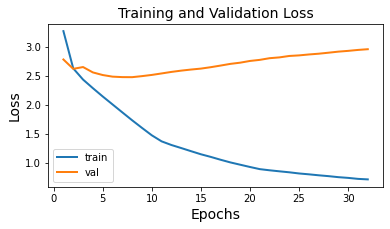

Epoch: 1


Training Epoch 1: 100%|██████████| 144/144 [00:09<00:00, 14.41it/s]


Training loss: 3.265054361687766


Validation Epoch 1: 100%|██████████| 46/46 [00:01<00:00, 24.51it/s]


Validation loss: 2.7773261847703354
Epoch 2, LR: 0.0001
Epoch: 2


Training Epoch 2: 100%|██████████| 144/144 [00:09<00:00, 15.64it/s]


Training loss: 2.624041087097592


Validation Epoch 2: 100%|██████████| 46/46 [00:01<00:00, 24.21it/s]


Validation loss: 2.6162323381589805
Epoch 3, LR: 0.0001
Epoch: 3


Training Epoch 3: 100%|██████████| 144/144 [00:09<00:00, 14.71it/s]


Training loss: 2.4316354774766498


Validation Epoch 3: 100%|██████████| 46/46 [00:01<00:00, 24.42it/s]


Validation loss: 2.5482643687206767
Epoch 4, LR: 0.0001
Epoch: 4


Training Epoch 4: 100%|██████████| 144/144 [00:09<00:00, 15.41it/s]


Training loss: 2.2839055127567716


Validation Epoch 4: 100%|██████████| 46/46 [00:01<00:00, 24.32it/s]


Validation loss: 2.50037593945213
Epoch 5, LR: 0.0001
Epoch: 5


Training Epoch 5: 100%|██████████| 144/144 [00:10<00:00, 14.33it/s]


Training loss: 2.141470638414224


Validation Epoch 5: 100%|██████████| 46/46 [00:01<00:00, 24.52it/s]


Validation loss: 2.4813115389450737
Epoch 6, LR: 0.0001
Epoch: 6


Training Epoch 6: 100%|██████████| 144/144 [00:09<00:00, 15.32it/s]


Training loss: 2.004577553934521


Validation Epoch 6: 100%|██████████| 46/46 [00:01<00:00, 25.29it/s]


Validation loss: 2.4650487847950147
Epoch 7, LR: 0.0001
Epoch: 7


Training Epoch 7: 100%|██████████| 144/144 [00:09<00:00, 14.80it/s]


Training loss: 1.8675577839215596


Validation Epoch 7: 100%|██████████| 46/46 [00:01<00:00, 25.34it/s]


Validation loss: 2.475978110147559
Epoch 8, LR: 0.0001
Epoch: 8


Training Epoch 8: 100%|██████████| 144/144 [00:09<00:00, 15.21it/s]


Training loss: 1.7315178645981684


Validation Epoch 8: 100%|██████████| 46/46 [00:01<00:00, 24.95it/s]


Validation loss: 2.478379197742628
Epoch 9, LR: 0.0001
Epoch: 9


Training Epoch 9: 100%|██████████| 144/144 [00:09<00:00, 15.53it/s]


Training loss: 1.6008504951993625


Validation Epoch 9: 100%|██████████| 46/46 [00:01<00:00, 25.18it/s]


Validation loss: 2.518708400104357
Epoch 10, LR: 0.0001
Epoch: 10


Training Epoch 10: 100%|██████████| 144/144 [00:09<00:00, 15.74it/s]


Training loss: 1.4732950338059


Validation Epoch 10: 100%|██████████| 46/46 [00:01<00:00, 25.23it/s]


Validation loss: 2.5380088246386983
Epoch 11, LR: 5e-05
Epoch: 11


Training Epoch 11: 100%|██████████| 144/144 [00:09<00:00, 14.43it/s]


Training loss: 1.3690116993255086


Validation Epoch 11: 100%|██████████| 46/46 [00:01<00:00, 24.68it/s]


Validation loss: 2.555165674375451
Epoch 12, LR: 5e-05
Epoch: 12


Training Epoch 12: 100%|██████████| 144/144 [00:09<00:00, 15.59it/s]


Training loss: 1.306185632944107


Validation Epoch 12: 100%|██████████| 46/46 [00:02<00:00, 20.62it/s]


Validation loss: 2.5975030245988266
Epoch 13, LR: 5e-05
Epoch: 13


Training Epoch 13: 100%|██████████| 144/144 [00:09<00:00, 15.70it/s]


Training loss: 1.2536649728814762


Validation Epoch 13: 100%|██████████| 46/46 [00:01<00:00, 23.84it/s]


Validation loss: 2.604393404463063
Epoch 14, LR: 5e-05
Epoch: 14


Training Epoch 14: 100%|██████████| 144/144 [00:08<00:00, 17.04it/s]


Training loss: 1.1999296206567023


Validation Epoch 14: 100%|██████████| 46/46 [00:01<00:00, 24.55it/s]


Validation loss: 2.6111851982448413
Epoch 15, LR: 5e-05
Epoch: 15


Training Epoch 15: 100%|██████████| 144/144 [00:09<00:00, 15.37it/s]


Training loss: 1.1470076619750924


Validation Epoch 15: 100%|██████████| 46/46 [00:01<00:00, 25.69it/s]


Validation loss: 2.645696194275566
Epoch 16, LR: 5e-05
Epoch: 16


Training Epoch 16: 100%|██████████| 144/144 [00:09<00:00, 15.52it/s]


Training loss: 1.101951748960548


Validation Epoch 16: 100%|██████████| 46/46 [00:01<00:00, 24.73it/s]


Validation loss: 2.6770560637764307
Epoch 17, LR: 5e-05
Epoch: 17


Training Epoch 17: 100%|██████████| 144/144 [00:08<00:00, 16.20it/s]


Training loss: 1.0529749757713742


Validation Epoch 17: 100%|██████████| 46/46 [00:01<00:00, 24.76it/s]


Validation loss: 2.6948057724081953
Epoch 18, LR: 5e-05
Epoch: 18


Training Epoch 18: 100%|██████████| 144/144 [00:08<00:00, 16.27it/s]


Training loss: 1.006975956261158


Validation Epoch 18: 100%|██████████| 46/46 [00:01<00:00, 23.99it/s]


Validation loss: 2.7333724913389785
Epoch 19, LR: 5e-05
Epoch: 19


Training Epoch 19: 100%|██████████| 144/144 [00:08<00:00, 16.23it/s]


Training loss: 0.9674424880908595


Validation Epoch 19: 100%|██████████| 46/46 [00:01<00:00, 25.17it/s]


Validation loss: 2.738785531209863
Epoch 20, LR: 5e-05
Epoch: 20


Training Epoch 20: 100%|██████████| 144/144 [00:08<00:00, 16.46it/s]


Training loss: 0.9282620772719383


Validation Epoch 20: 100%|██████████| 46/46 [00:01<00:00, 24.07it/s]


Validation loss: 2.784217259158259
Epoch 21, LR: 2.5e-05
Epoch: 21


Training Epoch 21: 100%|██████████| 144/144 [00:09<00:00, 14.92it/s]


Training loss: 0.8911261260509491


Validation Epoch 21: 100%|██████████| 46/46 [00:01<00:00, 24.57it/s]


Validation loss: 2.789345891579338
Epoch 22, LR: 2.5e-05
Epoch: 22


Training Epoch 22: 100%|██████████| 144/144 [00:08<00:00, 16.15it/s]


Training loss: 0.8711974256568484


Validation Epoch 22: 100%|██████████| 46/46 [00:01<00:00, 24.86it/s]


Validation loss: 2.825131162353184
Epoch 23, LR: 2.5e-05
Epoch: 23


Training Epoch 23: 100%|██████████| 144/144 [00:09<00:00, 15.93it/s]


Training loss: 0.8536315610011419


Validation Epoch 23: 100%|██████████| 46/46 [00:01<00:00, 23.76it/s]


Validation loss: 2.825714354929717
Epoch 24, LR: 2.5e-05
Epoch: 24


Training Epoch 24: 100%|██████████| 144/144 [00:08<00:00, 16.28it/s]


Training loss: 0.8367849977480041


Validation Epoch 24: 100%|██████████| 46/46 [00:01<00:00, 24.55it/s]


Validation loss: 2.8628971576690674
Epoch 25, LR: 2.5e-05
Epoch: 25


Training Epoch 25: 100%|██████████| 144/144 [00:09<00:00, 15.79it/s]


Training loss: 0.8167403125100665


Validation Epoch 25: 100%|██████████| 46/46 [00:01<00:00, 24.43it/s]


Validation loss: 2.8547163009643555
Epoch 26, LR: 2.5e-05
Epoch: 26


Training Epoch 26: 100%|██████████| 144/144 [00:09<00:00, 15.79it/s]


Training loss: 0.8019185732636187


Validation Epoch 26: 100%|██████████| 46/46 [00:01<00:00, 25.40it/s]


Validation loss: 2.87346263035484
Epoch 27, LR: 2.5e-05
Epoch: 27


Training Epoch 27: 100%|██████████| 144/144 [00:08<00:00, 16.12it/s]


Training loss: 0.785247857371966


Validation Epoch 27: 100%|██████████| 46/46 [00:01<00:00, 25.21it/s]


Validation loss: 2.902091891869255
Epoch 28, LR: 2.5e-05
Epoch: 28


Training Epoch 28: 100%|██████████| 144/144 [00:09<00:00, 15.47it/s]


Training loss: 0.7705635482238399


Validation Epoch 28: 100%|██████████| 46/46 [00:01<00:00, 25.26it/s]


Validation loss: 2.9064958147380664
Epoch 29, LR: 2.5e-05
Epoch: 29


Training Epoch 29: 100%|██████████| 144/144 [00:08<00:00, 16.04it/s]


Training loss: 0.7530939922564559


Validation Epoch 29: 100%|██████████| 46/46 [00:01<00:00, 25.46it/s]


Validation loss: 2.9284920951594478
Epoch 30, LR: 2.5e-05
Epoch: 30


Training Epoch 30: 100%|██████████| 144/144 [00:09<00:00, 15.83it/s]


Training loss: 0.7406326292289628


Validation Epoch 30: 100%|██████████| 46/46 [00:01<00:00, 24.24it/s]


Validation loss: 2.9415111541748047
Epoch 31, LR: 1.25e-05
Epoch: 31


Training Epoch 31: 100%|██████████| 144/144 [00:08<00:00, 16.38it/s]


Training loss: 0.7236353626681699


Validation Epoch 31: 100%|██████████| 46/46 [00:01<00:00, 25.23it/s]


Validation loss: 2.9551048486129097
Epoch 32, LR: 1.25e-05
Epoch: 32


Training Epoch 32: 100%|██████████| 144/144 [00:08<00:00, 16.03it/s]


Training loss: 0.7148003193239371


Validation Epoch 32: 100%|██████████| 46/46 [00:01<00:00, 24.18it/s]


Validation loss: 2.9658482955849688
Epoch 33, LR: 1.25e-05
Epoch: 33


Training Epoch 33:  37%|███▋      | 53/144 [00:03<00:05, 17.20it/s]

In [ ]:
# https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn
# Optionally introduce gradient clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.25)

fig_loss, ax_loss = plt.subplots(1, 1)
fig_loss.set_figwidth(6)
fig_loss.set_figheight(3)

display_loss = display(1, display_id=True)

optimizer.zero_grad()
# Training loop
for epoch in range(1, 101):
    print(f'Epoch: {epoch}')
    
    loss = train(model, converter, optimizer, train_dl, epoch, loss_obj=criterion, device=device)
    print(f"Training loss: {loss}")
    train_loss_hist.append(loss)
    
    val_loss = test(model, converter, test_dl, epoch, loss_obj=criterion, device=device)
    val_loss_hist.append(val_loss)
    print(f"Validation loss: {val_loss}")
    
    ax_loss.clear()
    plot_loss(train_loss_hist, val_loss_hist, ax=ax_loss, n=1)
    display_loss.update(fig_loss)
    time.sleep(1)
    
    scheduler.step()
    print(f"Epoch {epoch+1}, LR: {scheduler.get_last_lr()[0]}")

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(10)
epochs = len(train_loss_hist)
ax.plot(range(1, epochs+1), moving_average(train_loss_hist, 8), label='train', linewidth=2)
ax.plot(range(1, epochs+1), moving_average(val_loss_hist, 8), label='val', linewidth=2)
ax.set_ylabel("Loss", fontsize=14)
ax.set_xlabel("Epochs", fontsize=14)
ax.set_title("Training and Validation Loss", fontsize=14)
ax.legend()

In [ ]:
date = f"{datetime.now():%Y-%m-%d}"
save_model(model, epoch, optimizer, train_loss_hist, val_loss_hist, model_folder, f"tranformer_date_{date}.pt")

## Test Full Event

In [ ]:
from EventGrouping import EventGrouping

In [ ]:
model2 = Transformer(vocab_size, d_model, num_heads, num_layers, d_ff, feature_num, max_nodes, max_seq_length, dropout).to(device)
weights = torch.load("/eos/user/c/czeh/tranformer_4.pt", weights_only=True)
model2.load_state_dict(weights["model_state_dict"])

In [ ]:
runner = EventGrouping(converter, model2, neighborhood=1, seq_length=input_length)
runner(dataset_test.get(0))

In [ ]:
model_feature_keys = np.array([0,  2,  3,  4,  6,  7, 10, 14, 15, 16, 17, 18, 22, 24, 25, 26, 28, 29])
dataset_training.__getitem__(0)[0][:, model_feature_keys][:, -1]

In [ ]:
dataset_test.get(0).cluster

In [ ]:
dataset_training.node_feature_keys[16]

In [ ]:
G = torch_geometric.utils.to_networkx(dataset_test.get(0), to_undirected=True)

In [ ]:
dataset_training.get(0).x[:, 16]

In [ ]:
fig, ax = plt.subplots(1, 1)
nx.draw(G, with_labels=True, ax=ax)

## Random Tests

In [ ]:
targets = dataset_training.__getitem__(0)[2]
mask = targets != -4
mask.unsqueeze(-1)

In [ ]:
targets[targets[:, -1] != -4, :]

In [ ]:
targets[mask].shape[0]/3

In [ ]:
opts = dataset_training.__getitem__(0)[1]
opts = torch.roll(opts, -1, dims=0)
opts[-1] = 5
opts

In [ ]:
out_mask = opts != -4
opts[out_mask].shape[0]

In [ ]:
targets = torch.reshape(targets[mask], (int(targets[mask].shape[0]/3), 3))

In [ ]:
targets[0, :]